# Initial guess algorithm in adiabatic quantum computing simulations
---

## Reading materials 
1. Quantum Optimization for Maximum Independent Set Using Rydberg Atom Arrays - Hannes Pichler
2. Lecture 32: Luby’s Algorithm for Maximal Independent Set - Gary Miller
3. A study of heuristic guesses for adiabatic quantum computation - Alejandro Perdomo-Ortiz

In [873]:
import numpy as np
import matplotlib.pyplot as plt
# The library for quantum adiabatic simulations.
from qutip import * 
from scipy import *
# The library used for the graph representation.  
import networkx as nx
from LubyAlgoHelper import *


## Suggested algorithm: Part I
The suggested adjustment to the algorithm is to add a heuristic guesses for each vertex based on it's degree in the graph.

The new hamiltonian is as follows:
$$H_0 = \sum_{n=1}^{N}\left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \sum_{n=1}^{N}\sigma_z^n$$

With $x_n$ being the guess:

$$x_n=\begin{cases}
|r\rangle & & \frac{1}{dv} \geq C\\ 
|g \rangle & & \frac{1}{dv} < C
\end{cases}$$

and $$\hat{q}_n = \hat{I}_N \otimes\hat{I}_{N-1} \otimes \dots \otimes \frac{1}{2}(\hat{I}-\sigma_z^n)\otimes \dots \otimes I_1$$


$dv$ is the degree of vertex v, and constant $C \in [0,1]$ defining which vertex is assumed to start at ground and which is assumed to start at Rydberg. 

**_NOTE:_** We don't want divergance in out initial guess, which will happen if two adjacent vertex are drawn to Rydberg. For step I, our way to solve this is to set $C=1$. Meaning that only if the vertex is a leaf, it will start at Rydberg. Of course no two leafs are adjacent so no divergance will accure. 

In fact we can prove easly that all leafs can always be in the MIS. 
Assuming that there is a leaf v and an MIS G that doesn't contain v, since $G \cup v$ is a bigger graph and isn't the MIS, the vertex k that's connected to v must be in G. We can create a new graph $G'$ which is the same as G but with v instead of k. That is clearly also an MIS of same size.

## Parameters


### Defining usefull matrixs  

$$
\sigma_x = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix} , \sigma_y = \begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix} , \sigma_z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
 , 
|0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
, |1\rangle  = \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

In [874]:
# System size - number of qubits
N = 5
DEGREE_MIN = 1


zero = basis(2, 0)
one = basis(2, 1)
# Useful matrices
si = qeye(2)
I_N = tensor([si] * N)  # Tensor product of identity operators
sx = sigmax()
sy = sigmay()
sz = sigmaz()

sx_list = []
one_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(tensor(op_list))

    op_list[n] = 0.5*(si - sz)
    sz_list.append(tensor(op_list))

    op_list[n] = one*one.dag()
    one_list.append(tensor(op_list))


### Hamiltonian parameters

Using page 4 of the article, we know the detuning ($\Delta(t)$) ,rabi frequency ($\Omega(t)$) and the rabi blockade radius($r_B$). 
$$\Delta(t) = \Delta_0 (2t/T-1)  $$
 $$ \Omega(t) = \Omega_0 sin^2(\pi t/T)$$
$$r_B = \left(C/\sqrt{(2\Omega)^2+\Delta^2}\right)^{1/6}$$

Where C is the interuction strength of rydberg atoms. We also use $\Omega_0 = 1$ and $\Delta_0/\Omega_0 = 6$.

To get the scale of the required T to finish the adiabatic transformation, we can look at different finish times:  
$$T = 5/\Omega_0 , 10/\Omega_0 ,\dots$$

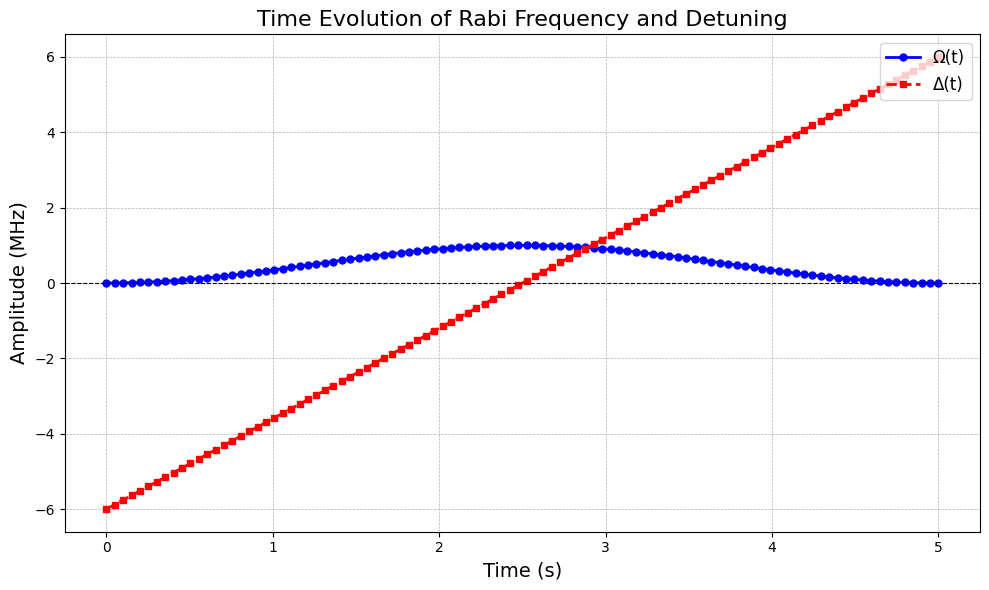

In [875]:
# Constants and System Parameters
TWO_PI = 2 * np.pi  # Useful for MHz
OMEGA_0 = 1  # Base Rabi frequency
DELTA_0 = 6 / OMEGA_0  # Initial detuning
TAU_MAX = 5 / OMEGA_0  # Maximum time (in units of OMEGA_0)
INTERACTION_STRENGTH = 8.6 * OMEGA_0  # Interaction strength constant
taulist = np.linspace(0, TAU_MAX, 100)  # Time points for plotting
delta=1 # Power of driving hamiltonian
# Calculate blockade radius
blockade_radius = round((INTERACTION_STRENGTH / np.sqrt((2 * OMEGA_0) ** 2 + DELTA_0 ** 2)) ** (1 / 6),10)

# Arguments for time-dependent functions
t_max = max(taulist)

# Time-dependent Rabi frequency (Ω) as a lambda function
def Omega(t):
    return OMEGA_0 * np.sin(np.pi * t / TAU_MAX) ** 2

# Time-dependent detuning (Δ) as a lambda function
def Delta(t):
    return DELTA_0 * (2 * t/TAU_MAX -1) 

timeEvoPlot(taulist,Omega,Delta)

### Choosing a Graph

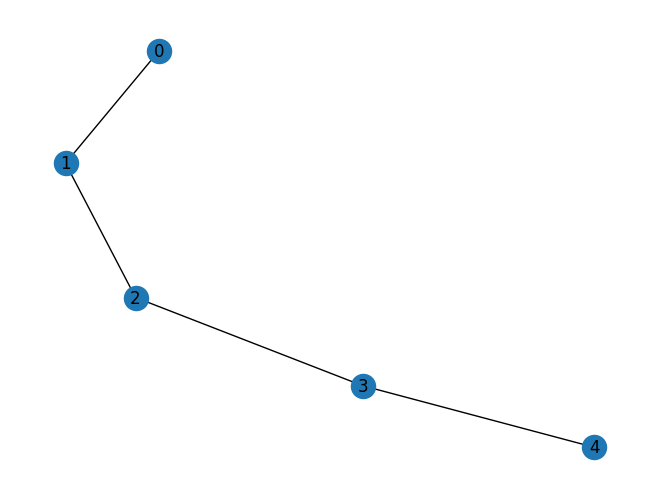

In [876]:
graph = [(i*blockade_radius,0) for i in range(N)]

# Create a graph object
G = nx.Graph()
for v in range(N):
    for w in range(v+1,N):
        dist_x = round(graph[v][0]-graph[w][0],10)
        dist_y = round(graph[v][1]-graph[w][1],10)
        dist = np.sqrt(dist_x**2+dist_y**2)
        if dist<=blockade_radius:
            G.add_edge(v, w)
        

#Plot the graph
nx.draw(G, with_labels=True)
plt.show()


### Construct the initial state


In [877]:
CL_H0 = I_N
for n in range(N):
    CL_H0 -=  sx_list[n]
    

GU_H0 = 0
Hd = 0
for n in range(N):
    guess = ((1/G.degree[n]) >= DEGREE_MIN)
    GU_H0 += guess*I_N + sz_list[n]*(1-2*guess)
    Hd += delta*sx_list[n]


psi_list = [basis(2, 0) for n in range(N)]
psi0 = tensor(psi_list)

### Construct evolution Hamiltonian
This code segment initializes and calculates the Hamiltonian for a system of \(N\) Rydberg atoms arranged in a two-dimensional space. 
$$H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w$$
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$

In [878]:
Hp = 0
H_int = 0

for v in range(N):
    Hp-= one_list[v] 
    for w in range(v+1,N):
        dist_x = graph[v][0]-graph[w][0]
        dist_y = graph[v][1]-graph[w][1]
        dist = np.sqrt(dist_x**2+dist_y**2)
        H_int +=  INTERACTION_STRENGTH / (dist)**6 *one_list[v] *  one_list[w]


classic_h_t = [[CL_H0, Omega],[Hp, Delta],H_int]
guess_h_t = [[GU_H0, Omega],[Hd,Omega],[Hp, Delta],H_int]
# transform Hamiltonian to QobjEvo
classic_h_t = QobjEvo(classic_h_t)
classic_result = sesolve(classic_h_t, psi0, taulist, [], {})

guess_h_t = QobjEvo(guess_h_t)
guess_result = sesolve(guess_h_t, psi0, taulist, [], {})


## Evolve the system in time
### General state analysis

## Results analysis

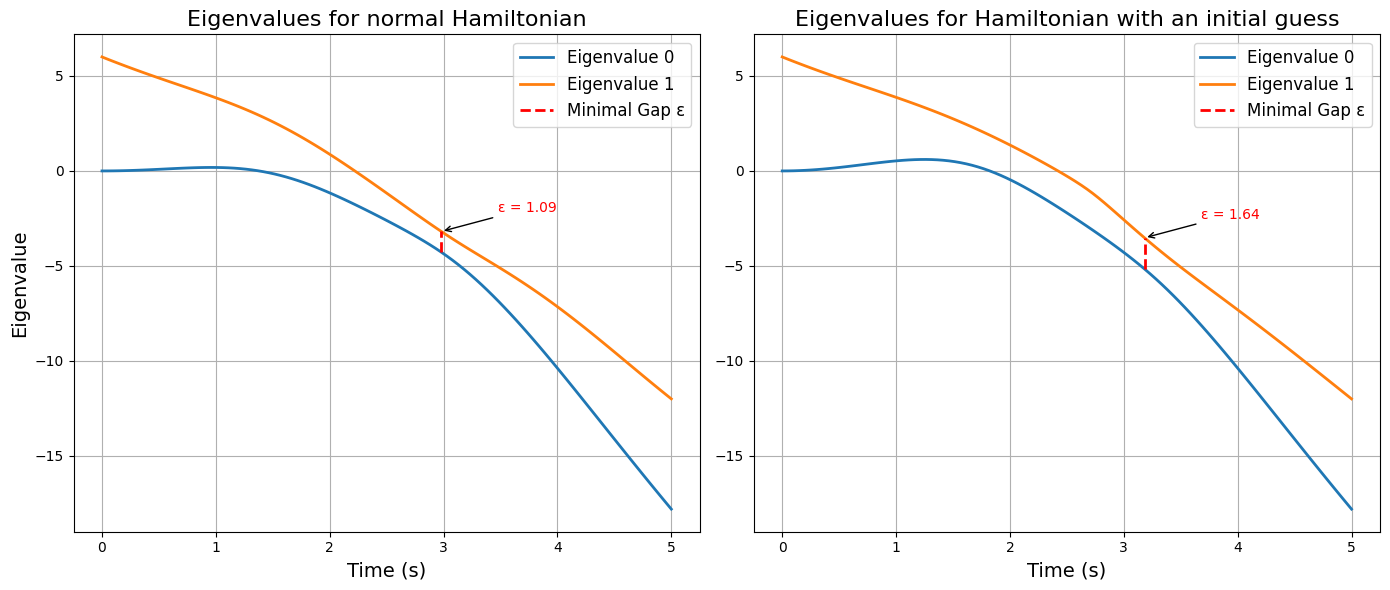

In [879]:
# Assuming taulist, h_t1, and h_t2 are defined earlier in your code
# Compute eigenvalues over the time list for both Hamiltonians
eigenvalues1 = np.zeros((len(taulist), 2**N))  # For the first Hamiltonian
eigenvalues2 = np.zeros((len(taulist), 2**N))  # For the second Hamiltonian
M=2

# Compute eigenvalues for h_t1
for i, t in enumerate(taulist):
    H1 = classic_h_t(t)  # Use the first Hamiltonian
    eigenvalues1[i, :] = H1.eigenenergies()

# Compute eigenvalues for h_t2
for i, t in enumerate(taulist):
    H2 = guess_h_t(t)  # Use the second Hamiltonian
    eigenvalues2[i, :] = H2.eigenenergies()

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Set figure size for side-by-side plots

# Plotting eigenvalues for the first Hamiltonian
for m in range(M):
    axs[0].plot(taulist, eigenvalues1[:, m], label=f"Eigenvalue {m}", linewidth=2)

# Calculate and annotate the minimal gap for the first Hamiltonian
lowest_eigenvalues1 = eigenvalues1[:, :2]
gap_values1 = lowest_eigenvalues1[:, 1] - lowest_eigenvalues1[:, 0]
epsilon1 = np.min(gap_values1)
gap_time_index1 = np.argmin(gap_values1)

# Draw the minimal gap line for the first Hamiltonian
axs[0].plot([taulist[gap_time_index1], taulist[gap_time_index1]],
            [lowest_eigenvalues1[gap_time_index1, 0], lowest_eigenvalues1[gap_time_index1, 1]],
            color='red', linestyle='--', linewidth=2, label='Minimal Gap ε')

# Add text annotations for the first Hamiltonian's eigenvalues and gap
axs[0].annotate(f'ε = {epsilon1:.2f}', 
                 xy=(taulist[gap_time_index1], lowest_eigenvalues1[gap_time_index1, 0] + epsilon1),
                 xytext=(taulist[gap_time_index1] + 0.5, lowest_eigenvalues1[gap_time_index1, 0] + epsilon1 + 1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, color='red')

# Titles and labels for the first plot
axs[0].set_title('Eigenvalues for normal Hamiltonian', fontsize=16)
axs[0].set_xlabel('Time (s)', fontsize=14)
axs[0].set_ylabel('Eigenvalue', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# Plotting eigenvalues for the second Hamiltonian
for m in range(M):
    axs[1].plot(taulist, eigenvalues2[:, m], label=f"Eigenvalue {m}", linewidth=2)

# Calculate and annotate the minimal gap for the second Hamiltonian
lowest_eigenvalues2 = eigenvalues2[:, :2]
gap_values2 = lowest_eigenvalues2[:, 1] - lowest_eigenvalues2[:, 0]
epsilon2 = np.min(gap_values2)
gap_time_index2 = np.argmin(gap_values2)

# Draw the minimal gap line for the second Hamiltonian
axs[1].plot([taulist[gap_time_index2], taulist[gap_time_index2]],
            [lowest_eigenvalues2[gap_time_index2, 0], lowest_eigenvalues2[gap_time_index2, 1]],
            color='red', linestyle='--', linewidth=2, label='Minimal Gap ε')

# Add text annotations for the second Hamiltonian's eigenvalues and gap
axs[1].annotate(f'ε = {epsilon2:.2f}', 
                 xy=(taulist[gap_time_index2], lowest_eigenvalues2[gap_time_index2, 0] + epsilon2),
                 xytext=(taulist[gap_time_index2] + 0.5, lowest_eigenvalues2[gap_time_index2, 0] + epsilon2 + 1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, color='red')

# Titles and labels for the second plot
axs[1].set_title('Eigenvalues for Hamiltonian with an initial guess', fontsize=16)
axs[1].set_xlabel('Time (s)', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


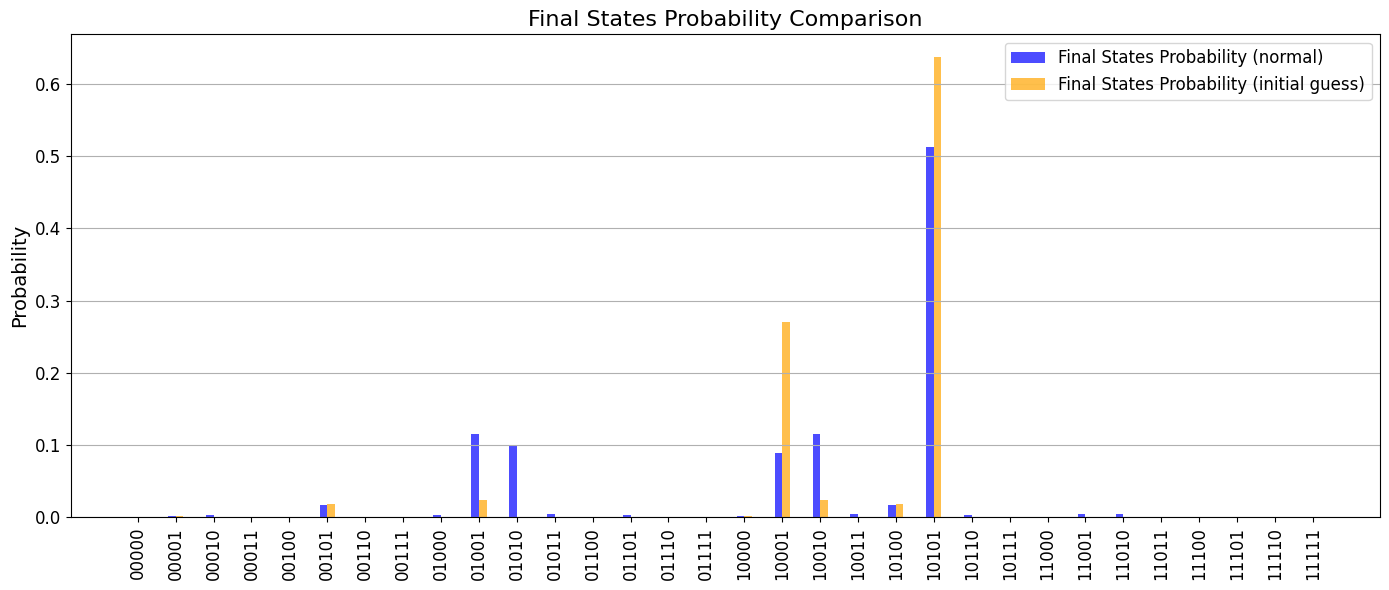

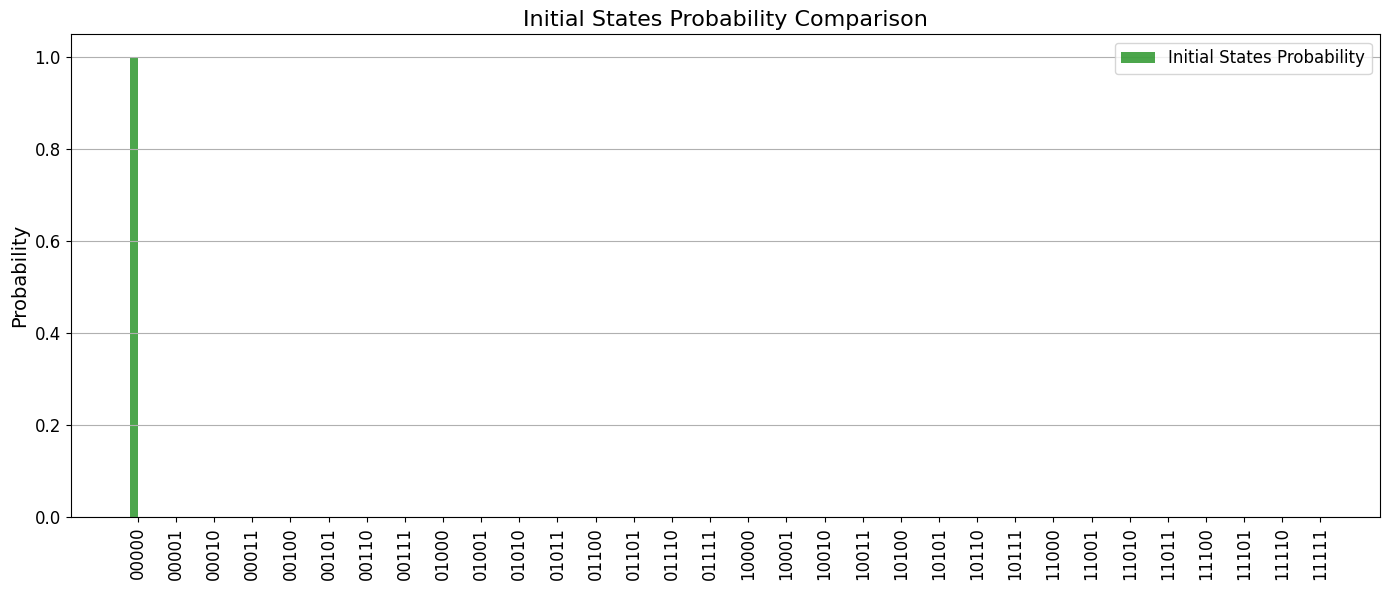

In [880]:
from itertools import product

# Define the digits
digits = [0, 1]

# Generate all combinations of states
combinations = product(digits, repeat=N)
lst = [''.join(map(str, combination)) for combination in combinations]

# Extract coefficients for final states for both results
coeff_final_1 = [np.abs(a_i[0])**2 for a_i in classic_result.states[-1].full()]
coeff_final_2 = [np.abs(a_i[0])**2 for a_i in guess_result.states[-1].full()]

# Extract coefficients for initial states for both results
coeff_initial_1 = [np.abs(a_i[0])**2 for a_i in psi0.full()]
coeff_initial_2 = [np.abs(a_i[0])**2 for a_i in psi0.full()]

# Create x positions for the bars
x = np.arange(len(lst))  # X positions for the bar graph

# Width of the bars
width = 0.2

# Create the bar plot for final states
plt.figure(figsize=(14, 6))
# Plotting final states probability for Result 1
plt.bar(x - width/2, coeff_final_1, width, label='Final States Probability (normal)', color='blue', alpha=0.7)
# Plotting final states probability for Result 2
plt.bar(x + width/2, coeff_final_2, width, label='Final States Probability (initial guess)', color='orange', alpha=0.7)

# Adding titles and labels for final states
plt.xticks(x, lst, fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylabel('Probability', fontsize=14)
plt.title('Final States Probability Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y')  # Enable grid on the y-axis
plt.tight_layout()  # Adjust layout

# Show the final states plot
plt.show()

# Create the bar plot for initial states
plt.figure(figsize=(14, 6))
# Plotting initial states probability for Psi 01
plt.bar(x - width/2, coeff_initial_1, width, label='Initial States Probability', color='green', alpha=0.7)
# # Plotting initial states probability for Psi 02
# plt.bar(x + width/2, coeff_initial_2, width, label='Initial States Probability (Psi 02)', color='red', alpha=0.7)

# Adding titles and labels for initial states
plt.xticks(x, lst, fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylabel('Probability', fontsize=14)
plt.title('Initial States Probability Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y')  # Enable grid on the y-axis
plt.tight_layout()  # Adjust layout

# Show the initial states plot
plt.show()